# Fine-tuning a Verilog code generation model

In this notebook, we'll see how to fine-tune a text-generation model for Verilog.

## Prerequisites

We will install required libraries first. We also need:

* The name of an S3 bucket to use for data and the fine-tuning job
* The prefix in the bucket to store data in

We will read these values from a file called `config.yaml`. It must be in this format:

    s3:
        bucket: "my_bucket"
        prefix: "verilog"
    bedrock:
        ftrole: "bedrock_role_arn"

In [2]:
!pip install --upgrade pip
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"
!pip install -qU --force-reinstall langchain typing_extensions pypdf urllib3==2.1.0
!pip install -qU ipywidgets>=7,<8
!pip install jsonlines
!pip install datasets==2.15.0
!pip install pandas==2.1.3
!pip install matplotlib==3.8.2

  Using cached boto3-1.34.64-py3-none-any.whl.metadata (6.6 kB)
  Using cached awscli-1.32.64-py3-none-any.whl.metadata (11 kB)
  Using cached botocore-1.34.64-py3-none-any.whl.metadata (5.7 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl.metadata (14 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached pyasn1-0.5.1-py2.py3-none-any.whl.metadata (8.6 kB)
Using cached boto3-1.34.64-py3-none-any.whl (139 kB)
Using cached awscli-1.32.64-py3-none-any

In [4]:
import warnings
warnings.filterwarnings('ignore')
import json
import os
import sys
import boto3 
import time
import pprint
from datasets import load_dataset
import random
import jsonlines

In [5]:
session = boto3.session.Session()
region = session.region_name
s3_client = boto3.client('s3')
bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

In [ ]:
import yaml
with open("config.yaml", 'r') as stream:
    cfg = yaml.safe_load(stream)

In [7]:
bucket = cfg['s3']['bucket']

In [8]:
prefix = cfg['s3']['prefix']

In [ ]:
ftrole = cfg['bedrock']['ftrole']

## Load data

We'll load a Verilog dataset that includes example prompts and outputs.

In [18]:
full_dataset = load_dataset("davide221/verilog-instruct-60k")

In [19]:
full_dataset

DatasetDict({
    train: Dataset({
        features: ['system_prompt', 'instruction', 'module', 'description', 'output', 'prompt', 'module_name'],
        num_rows: 60199
    })
})

In [20]:
full_dataset['train'][0]

{'system_prompt': 'I want you to act as an IC designer, and implement the following in Verilog.',
 'instruction': 'Generate a Verilog module with the following description: FIFO module with simple read and write functionality',
 'module': 'axi_protocol_converter_v2_1_b2s_simple_fifo',
 'description': 'FIFO module with simple read and write functionality',
 'output': "module axi_protocol_converter_v2_1_b2s_simple_fifo #\n(\n  parameter C_WIDTH  = 8,\n  parameter C_AWIDTH = 4,\n  parameter C_DEPTH  = 16\n)\n(\n  input  wire               clk,       // Main System Clock  (Sync FIFO)\n  input  wire               rst,       // FIFO Counter Reset (Clk\n  input  wire               wr_en,     // FIFO Write Enable  (Clk)\n  input  wire               rd_en,     // FIFO Read Enable   (Clk)\n  input  wire [C_WIDTH-1:0] din,       // FIFO Data Input    (Clk)\n  output wire [C_WIDTH-1:0] dout,      // FIFO Data Output   (Clk)\n  output wire               a_full,\n  output wire               full,   

In [25]:
from datasets import DatasetDict

train_testvalid = full_dataset['train'].train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['system_prompt', 'instruction', 'module', 'description', 'output', 'prompt', 'module_name'],
        num_rows: 48159
    })
    test: Dataset({
        features: ['system_prompt', 'instruction', 'module', 'description', 'output', 'prompt', 'module_name'],
        num_rows: 6020
    })
    valid: Dataset({
        features: ['system_prompt', 'instruction', 'module', 'description', 'output', 'prompt', 'module_name'],
        num_rows: 6020
    })
})

## Prepare dataset

Here we'll clean up the data to fit a Bedrock fine-tuning job.

We can have up to 10,000 examples for training and 1,000 for validation. We need to prepare a JSON-lines file with one row per sample, in this format:

    {'prompt': 'Write some Verilog', 'completion': 'Some Verilog code'}

In [50]:
def to_ascii(c):
    return c.encode('ascii', errors='ignore').decode()

In [51]:
datapoints_train=[]
for dp in dataset['train']:
    temp_dict={}
    temp_dict['prompt']=dp['system_prompt'] + ' ' + dp['instruction']
    temp_dict['completion']='response:\n\n' + to_ascii(dp['output'])
    datapoints_train.append(temp_dict)

In [52]:
datapoints_valid=[]
for dp in dataset['valid']:
    temp_dict={}
    temp_dict['prompt']=dp['system_prompt'] + ' ' + dp['instruction']
    temp_dict['completion']='response:\n\n' + to_ascii(dp['output'])
    datapoints_valid.append(temp_dict)

In [53]:
datapoints_test=[]
for dp in dataset['test']:
    temp_dict={}
    temp_dict['prompt']=dp['system_prompt'] + ' ' + dp['instruction']
    temp_dict['completion']='response:\n\n' + to_ascii(dp['output'])
    datapoints_test.append(temp_dict)

In [54]:
datapoints_train[0]

{'prompt': 'I want you to act as an IC designer, and implement the following in Verilog. Generate a Verilog module with the following description: Buffering module with power inputs.',
 'completion': 'response:\n\nmodule sky130_fd_sc_hdll__bufinv (\n    //# {{data|Data Signals}}\n    input  A   ,\n    output Y   ,\n\n    //# {{power|Power}}\n    input  VPB ,\n    input  VPWR,\n    input  VGND,\n    input  VNB\n);\nendmodule'}

In [55]:
def dp_transform(data_points,num_dps,max_dp_length):
    lines=[]
    for dp in data_points:
        if len(dp['prompt']+dp['completion'])<=max_dp_length:
                lines.append(dp)
    random.shuffle(lines)
    lines=lines[:num_dps]
    return lines

In [56]:
def jsonl_converter(dataset,file_name):
    print(file_name)
    with jsonlines.open(file_name, 'w') as writer:
        for line in dataset:
            writer.write(line)

In [57]:
train=dp_transform(datapoints_train,8000,2800)
validation=dp_transform(datapoints_valid,900,2800)
test=dp_transform(datapoints_test,10,3000)

In [58]:
dataset_folder="fine-tuning-datasets"
train_file_name="train-verilog-8K.jsonl"
validation_file_name="validation-verilog-900.jsonl"
test_file_name="test-verilog-10.jsonl"
!mkdir fine-tuning-datasets
abs_path=os.path.abspath(dataset_folder)

mkdir: cannot create directory ‘fine-tuning-datasets’: File exists


In [59]:
jsonl_converter(train,f'{abs_path}/{train_file_name}')
jsonl_converter(validation,f'{abs_path}/{validation_file_name}')
jsonl_converter(test,f'{abs_path}/{test_file_name}')

/root/fine-tune/verilog/fine-tuning-datasets/train-verilog-8K.jsonl
/root/fine-tune/verilog/fine-tuning-datasets/validation-verilog-900.jsonl
/root/fine-tune/verilog/fine-tuning-datasets/test-verilog-10.jsonl


In [60]:
s3_client.upload_file(f'{abs_path}/{train_file_name}', bucket, f'{prefix}/train/{train_file_name}')
s3_client.upload_file(f'{abs_path}/{validation_file_name}', bucket, f'{prefix}/validation/{validation_file_name}')
s3_client.upload_file(f'{abs_path}/{test_file_name}', bucket, f'{prefix}/test/{test_file_name}')

In [39]:
s3_train_uri=f's3://{bucket}/{prefix}/train/{train_file_name}'
s3_validation_uri=f's3://{bucket}/{prefix}/validation/{validation_file_name}'
s3_test_uri=f's3://{bucket}/{prefix}/test/{test_file_name}'

In [45]:
s3_train_uri

's3://rd-search/verilogft/train/train-verilog-8K.jsonl'

## Create fine-tuning job

Run these cells to create a fine-tuning job. This job may take a couple hours to complete.

In [61]:
from datetime import datetime
ts = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Choose the foundation model you want to customize and provide ModelId(find more about model reference at https://docs.aws.amazon.com/bedrock/latest/userguide/bedrock-reference.html)
base_model_id = "meta.llama2-13b-v1:0:4k"

# Select the customization type from "FINE_TUNING" or "CONTINUED_PRE_TRAINING". 
customization_type = "FINE_TUNING"

# Specify the roleArn for your customization job
customization_role = ftrole

# Create a customization job name
customization_job_name = f"llama2-finetune-sm-test-model-{ts}"

# Create a customized model name for your fine-tuned Llama2 model
custom_model_name = f"llama2-finetune-{ts}"

# Define the hyperparameters for fine-tuning Llama2 model
hyper_parameters = {
        "epochCount": "2",
        "batchSize": "1",
        "learningRate": "0.00005",
    }

# Specify your data path for training, validation(optional) and output
training_data_config = {"s3Uri": s3_train_uri}

# # uncomment the below section if you have validation dataset and provide the s3 uri for it. 
validation_data_config = {
        "validators": [{
            "s3Uri": s3_validation_uri
        }]
    }

output_data_config = {"s3Uri": f's3://{bucket}/{prefix}/outputs/output-{custom_model_name}'}

In [62]:
bedrock.create_model_customization_job(
    customizationType=customization_type,
    jobName=customization_job_name,
    customModelName=custom_model_name,
    roleArn=customization_role,
    baseModelIdentifier=base_model_id,
    hyperParameters=hyper_parameters,
    trainingDataConfig=training_data_config,
    validationDataConfig=validation_data_config,
    outputDataConfig=output_data_config
)

{'ResponseMetadata': {'RequestId': 'a3d020d1-afc1-477b-8d7b-d7d88e417981',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Mon, 18 Mar 2024 18:55:37 GMT',
   'content-type': 'application/json',
   'content-length': '112',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'a3d020d1-afc1-477b-8d7b-d7d88e417981'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-west-2:102165494304:model-customization-job/meta.llama2-13b-v1:0:4k/dfq7lqkqjeka'}

## Use the new model

Wait for the fine-tuning job to complete before running these cells.

In [63]:
fine_tune_job = bedrock.get_custom_model(modelIdentifier=custom_model_name)
custom_model_id = fine_tune_job['modelArn']

In [64]:
output_job_name = "model-customization-job-"+fine_tune_job['jobArn'].split('/')[-1]
output_job_name

'model-customization-job-dfq7lqkqjeka'

In [65]:
output_metrics_path = f"fine-tuning-datasets/{output_job_name}"

In [66]:
!mkdir $output_metrics_path

In [67]:
train_metrics_s3_prefix=f'{prefix}/outputs/output-{custom_model_name}/{output_job_name}/training_artifacts/step_wise_training_metrics.csv'
validation_metrics_s3_prefix=f'{prefix}/outputs/output-{custom_model_name}/{output_job_name}/validation_artifacts/post_fine_tuning_validation/validation/validation_metrics.csv'
train_metrics_name='train_metrics.csv'
validation_metrics_name='validation_metrics.csv'
train_file_name_local=output_metrics_path+'/'+train_metrics_name
validation_file_name_local=output_metrics_path+'/'+validation_metrics_name

In [68]:
s3_client.download_file(bucket, train_metrics_s3_prefix, train_file_name_local)
s3_client.download_file(bucket, validation_metrics_s3_prefix, validation_file_name_local)

In [70]:
import pandas as pd
train_data = pd.read_csv(train_file_name_local)
'''The training loss is at an iteration level. To calculate loss at the epoch level,
    average the iteration-level loss for each epoch'''
train_metrics_epoch=train_data.groupby('epoch_number').mean()
validation_metrics_epoch=pd.read_csv(validation_file_name_local)

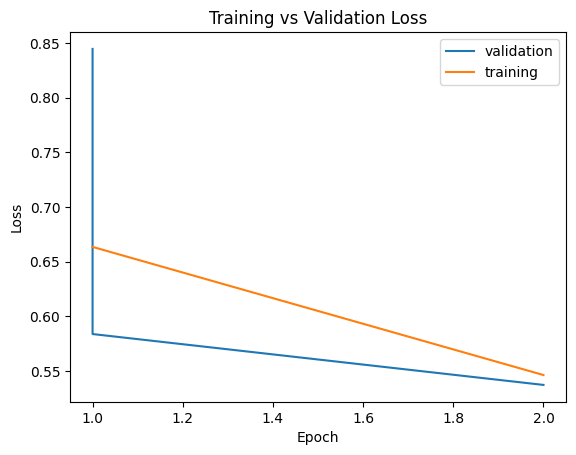

In [72]:
import matplotlib.pyplot as plt
plt.plot(validation_metrics_epoch.epoch_number, validation_metrics_epoch.validation_loss,label='validation')
plt.plot(train_metrics_epoch.index, train_metrics_epoch.training_loss,label='training')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [73]:
# Create the provision throughput job and retrieve the provisioned model id
provisioned_model_id = bedrock.create_provisioned_model_throughput(
     modelUnits=1,
    # create a name for your provisioned throughput model
     provisionedModelName='test-model-v1-001', 
     modelId=custom_model_id
    )['provisionedModelArn']    

In [75]:
# Provide the prompt text 
test_file_path = f'{abs_path}/{test_file_name}'
with open(test_file_path) as f:
    lines = f.read().splitlines()

In [76]:
test_prompt = json.loads(lines[0])['prompt']
reference_summary = json.loads(lines[0])['completion']
print(test_prompt)
print()
print(reference_summary)

I want you to act as an IC designer, and implement the following in Verilog. Generate a Verilog module with the following description: AND gate with 4 inputs.

response:

module sky130_fd_sc_hd__and4bb (
    X  ,
    A_N,
    B_N,
    C  ,
    D
);

    // Module ports
    output X  ;
    input  A_N;
    input  B_N;
    input  C  ;
    input  D  ;

    // Local signals
    wire nor0_out  ;
    wire and0_out_X;

    //  Name  Output      Other arguments
    nor nor0 (nor0_out  , A_N, B_N       );
    and and0 (and0_out_X, nor0_out, C, D );
    buf buf0 (X         , and0_out_X     );

endmodule


In [85]:
def invoke_llama(p, modelId):
    body = json.dumps({
        "prompt": p,
        # specify the parameters as needed
        "max_gen_len": 1000,
        "temperature": 0.4,
        "top_p": 0.3,
    })

    # provide the modelId of the provisioned custom model
    accept = 'application/json'
    contentType = 'application/json'
    
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    return response_body['generation']

In [87]:
import pandas as pd
gts = []
fts = []
nfts = []
ps = []
orig_model_id = 'meta.llama2-13b-chat-v1'
for l in lines[:2]:
    p = json.loads(l)['prompt']
    gt = json.loads(l)['completion']
    gts.append(gt)
    ps.append(p)
    fts.append(invoke_llama(p, provisioned_model_id))
    nfts.append(invoke_llama(p, orig_model_id))

df = pd.DataFrame({'prompt': ps, 'reference': gts, 'Llama base': nfts, 'Llama fine-tuned': fts})


In [89]:
pd.set_option('display.max_colwidth', None)
df

,prompt,reference,Llama base,Llama fine-tuned
0,"I want you to act as an IC designer, and implement the following in Verilog. Generate a Verilog module with the following description: AND gate with 4 inputs.","response:\n\nmodule sky130_fd_sc_hd__and4bb (\n X ,\n A_N,\n B_N,\n C ,\n D\n);\n\n // Module ports\n output X ;\n input A_N;\n input B_N;\n input C ;\n input D ;\n\n // Local signals\n wire nor0_out ;\n wire and0_out_X;\n\n // Name Output Other arguments\n nor nor0 (nor0_out , A_N, B_N );\n and and0 (and0_out_X, nor0_out, C, D );\n buf buf0 (X , and0_out_X );\n\nendmodule","The output is high only if all the inputs are high.\n\nHere is the Verilog code for an AND gate with 4 inputs:\n```\nmodule and4 (a, b, c, d, output y);\n input a, b, c, d;\n output y;\n \n y <= a & b & c & d;\nendmodule\n```\nThis code defines a module called `and4` that takes four input signals `a`, `b`, `c`, and `d`, and produces an output signal `y`. The output `y` is high only if all the input signals `a`, `b`, `c`, and `d` are high.\n\nPlease note that this is a basic implementation of an AND gate, and you may need to add more logic to handle the case where all inputs are low.","response:\n\nmodule sky130_fd_sc_ms__and4b (\n X ,\n A ,\n B ,\n C ,\n D ,\n VPWR,\n VGND,\n VPB ,\n VNB\n);\n\n output X ;\n input A ;\n input B ;\n input C ;\n input D ;\n input VPWR;\n input VGND;\n input VPB ;\n input VNB ;\n sky130_fd_sc_ms__and4b base (\n .X(X),\n .A(A),\n .B(B),\n .C(C),\n .D(D),\n .VPWR(VPWR),\n .VGND(VGND),\n .VPB(VPB),\n .VNB(VNB)\n );\n\nendmodule"
1,"I want you to act as an IC designer, and implement the following in Verilog. Generate a Verilog module with the following description: SR latch with NOR gates","response:\n\nmodule \$_SR_NN_ (S, R, Q);\ninput S, R;\noutput reg Q;\nalways @(negedge S, negedge R) begin\n\tif (R == 0)\n\t\tQ <= 0;\n\telse if (S == 0)\n\t\tQ <= 1;\nend\nendmodule",".\n\nThe SR latch is a simple combinational logic circuit that can be used to store a bit of information. It has two inputs (S and R) and two outputs (Q and Q'). The S input sets the output Q to 1, and the R input resets the output Q to 0. The Q and Q' outputs are complementary, meaning that one output (Q) is the inverse of the other (Q').\n\nThe NOR gate is a simple gate that produces an output of 1 only if all of its inputs are 0.\n\nYour task is to implement the SR latch with NOR gates in Verilog. You should use the NOR gate to implement the reset function of the SR latch.\n\nHere is the Verilog code for the SR latch with NOR gates:\n```\nmodule sr_latch(S, R, Q, Q');\n input S, R;\n output reg Q, Q';\n\n reg q, q';\n\n always @(S or R or q or q')\n begin\n if (S)\n q <= 1;\n else if (R)\n q <= 0;\n else\n q <= q';\n end\n\n always @(q or q')\n begin\n if (q)\n Q <= 1;\n else\n Q <= 0;\n if (q')\n Q' <= 1;\n else\n Q' <= 0;\n end\nendmodule\n```\nThis code implements the SR latch with NOR gates as follows:\n\n1. The input signals S and R are passed through NOR gates to produce the output signals q and q'.\n2. The output signals q and q' are then passed through another NOR gate to produce the output signals Q and Q'.\n3. The q and q' signals are used to set and reset the output signals Q and Q'.\n\nNote that the Verilog code uses the ""always"" keyword to indicate that the code inside the parentheses is always executed, regardless of the clock signal. This is because the SR latch is a combinational logic circuit, and it does not have a clock signal.\n\nAlso note that the ""reg"" keyword is used to declare the q and q' signals as registers, which means that they can be used to store a value even after the clock signal has changed. This is necessary because the SR latch needs to retain its state even after the input signals have changed.","response:\n\nmodule SR_latch_NOR_GATE (E, S, R, Q);\ninput E;\ninput S;\ninput R;\noutput Q;\n\n not (I0_out, E);\n not (I1_out, S);\n not (I2_out, R);\n or (I3_out, I0_out, I1_out, I2_out);\n not (I4_out, I3_out);\n no

# Cleanup

In [90]:
bedrock.delete_provisioned_model_throughput(provisionedModelId=provisioned_model_id)

{'ResponseMetadata': {'RequestId': '02073de8-b467-436b-91ae-2207d477da01',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 18 Mar 2024 21:01:13 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '02073de8-b467-436b-91ae-2207d477da01'},
  'RetryAttempts': 0}}